In [420]:
import datetime
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# Construct the dataset

In [421]:
def downloadData():

    first_date = (datetime.date(2020, 2, 24))
    last_date = (datetime.date(2022, 8, 4))

    for delta in range(1, (last_date - first_date).days):

        today = first_date + datetime.timedelta(days=delta)
        today_url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+today.strftime("%Y%m%d")+'.csv'
        present = pd.read_csv(today_url)
        present.to_csv('date_datasets/'+today.strftime("%Y%m%d")+'.csv', index=False)

In [422]:
#downloadData()

In [423]:
regioni = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Friuli-Venezia Giulia", "Lazio", "Liguria", "Lombardia", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]
regioni_no_friuli = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]

first_date = (datetime.date(2020, 9, 1))   # perché all'inizio i dati erano sballati
last_date = (datetime.date(2022, 8, 4))

In [424]:
def dateToRegion(regioni, first_date, last_date):

    for regione in regioni_no_friuli:

        regione_csv = pd.DataFrame(data={"perc_story": [], "ospedalizzati_story": []})

        for delta in range(1, (last_date - first_date).days):
            # open the files
            today = first_date + datetime.timedelta(days=delta)
            yesterday = today - datetime.timedelta(days=1)
            present = pd.read_csv('date_datasets/'+today.strftime("%Y%m%d")+'.csv')
            past = pd.read_csv('date_datasets/'+yesterday.strftime("%Y%m%d")+'.csv')
            regione_present = present[ present['denominazione_regione'] == regione ]
            regione_past = past[ past['denominazione_regione'] == regione ]
            # compute the perc
            try:
                tot_tamponi_present = regione_present['tamponi'].values[0]
            except:
                print(regione)
                print(today)
                print(regione_present['tamponi'])
            tot_tamponi_past = regione_past['tamponi'].values[0]
            tamponi_oggi = tot_tamponi_present - tot_tamponi_past
            nuovi_positivi = regione_present['nuovi_positivi'].values[0]
            percentuale = np.around(nuovi_positivi / tamponi_oggi * 100, 2)     # <---
            # compute the hospitalized
            ospedalizzati_attuali = regione_present['totale_ospedalizzati'].values[0]       # <---
            # append the row
            nuova_riga = pd.DataFrame([[percentuale, ospedalizzati_attuali]],
                                        columns=["perc_story", "ospedalizzati_story"])
            regione_csv = pd.concat([regione_csv, nuova_riga])
        
        regione_csv.to_csv(f"region_datasets/{regione}.csv", index=False)

In [425]:
#dateToRegion(regioni_no_friuli, first_date, last_date)

# Preprocess the datasets

In [426]:
def preprocessDatasets(regions_array, window_length, perc_shift=14):

    global_dataset = np.empty([0, window_length, 3])

    for regione in regions_array:

        dataset = pd.read_csv(f"region_datasets/{regione}.csv").replace([np.inf, -np.inf], np.nan).interpolate()

        # mean and shift the perc
        perc = dataset['perc_story']
        perc = perc.rolling(window=7, min_periods=1).mean()
        perc = perc.shift(perc_shift).dropna()
        perc = perc.values

        # drop the first perc_shift ospedalizzati
        ospedalizzati = dataset['ospedalizzati_story'][perc_shift:].values

        days_array = np.arange(len(perc))

        dataset = np.column_stack((days_array, ospedalizzati, perc))

        # create the windows
        indexer = np.arange(window_length)[None, :] + np.arange(dataset.shape[0]-window_length)[:, None]
        dataset = dataset[indexer]

        global_dataset = np.vstack((global_dataset, dataset))

    return global_dataset

In [427]:
regioni_no_friuli_no_lomba = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]
# regioni_pop = [["Abruzzo", 1_312_000],
#                                 ["Basilicata", 562_869],
#                                 ["Calabria", 1_947_000],
#                                 ["Campania", 5_576_303],
#                                 ["Emilia-Romagna", 4_459_000],
#                                 ["Lazio", 5_879_000],
#                                 ["Liguria", 1_551_000],
#                                 ["Marche", 1_525_000],
#                                 ["Molise", 305_617],
#                                 ["P.A. Bolzano", 535_829],
#                                 ["P.A. Trento", 542_150],
#                                 ["Piemonte", 4_245_059],
#                                 ["Puglia", 3_900_822],
#                                 ["Sardegna", 1_573_089],
#                                 ["Sicilia", 4_789_826],
#                                 ["Toscana", 3_678_941],
#                                 ["Umbria", 858_478],
#                                 ["Valle d'Aosta", 123_102],
#                                 ["Veneto", 4_848_069]]

window_length = 28

In [428]:
scaler = MinMaxScaler()

In [429]:
# training_set = preprocessDatasets(regioni_no_friuli_no_lomba, window_length)

# batch_size, timesteps, features = training_set.shape
# training_set = training_set.reshape(batch_size * timesteps, features)
# training_set = scaler.fit_transform(training_set)                       # <---
# training_set = training_set.reshape(batch_size, timesteps, features)

# # Input
# train_input_days = torch.from_numpy(training_set[..., 0]).type(torch.FloatTensor)
# train_input_ospedalizzati = torch.from_numpy(training_set[:, :window_length//2, 1]).type(torch.FloatTensor)
# train_input_perc = torch.from_numpy(training_set[..., 2]).type(torch.FloatTensor)

# # Output
# train_target = torch.from_numpy(training_set[:, int(3/4*window_length)-1:window_length:window_length//4, 1]).type(torch.FloatTensor)

# test_set = preprocessDatasets(["Lombardia"], window_length)
# #test_set = preprocessDatasets([["Lombardia", 9_961_801]], window_length)

# batch_size, timesteps, features = test_set.shape
# test_set = test_set.reshape(batch_size * timesteps, features)
# #test_set = scaler.transform(test_set)                              # <---
# test_set = scaler.fit_transform(test_set)
# test_set = test_set.reshape(batch_size, timesteps, features)

# # Input
# test_input_days = torch.from_numpy(test_set[..., 0]).type(torch.FloatTensor)
# test_input_ospedalizzati = torch.from_numpy(test_set[:, :window_length//2, 1]).type(torch.FloatTensor)
# test_input_perc = torch.from_numpy(test_set[..., 2]).type(torch.FloatTensor)

# # Output
# test_target = torch.from_numpy(test_set[:, int(3/4*window_length)-1:window_length:window_length//4, 1]).type(torch.FloatTensor)

In [430]:
dataset = preprocessDatasets(["Lombardia"], window_length)

batch_size, timesteps, features = dataset.shape
dataset = dataset.reshape(batch_size * timesteps, features)
dataset = scaler.fit_transform(dataset)
dataset = dataset.reshape(batch_size, timesteps, features)

training_set = dataset[:int(0.9*len(dataset))]
test_set = dataset[int(0.9*len(dataset)):]

# Input
train_input_days = torch.from_numpy(training_set[..., 0]).type(torch.FloatTensor)
train_input_ospedalizzati = torch.from_numpy(training_set[:, :window_length//2, 1]).type(torch.FloatTensor)
train_input_perc = torch.from_numpy(training_set[..., 2]).type(torch.FloatTensor)

# Output
train_target = torch.from_numpy(training_set[:, int(3/4*window_length)-1:window_length:window_length//4, 1]).type(torch.FloatTensor)

# Input
test_input_days = torch.from_numpy(test_set[..., 0]).type(torch.FloatTensor)
test_input_ospedalizzati = torch.from_numpy(test_set[:, :window_length//2, 1]).type(torch.FloatTensor)
test_input_perc = torch.from_numpy(test_set[..., 2]).type(torch.FloatTensor)

# Output
test_target = torch.from_numpy(test_set[:, int(3/4*window_length)-1:window_length:window_length//4, 1]).type(torch.FloatTensor)

## The network

In [431]:
class MLP(torch.nn.Module):

    def __init__(self, window_length):
        super().__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(int(5/2*window_length), 4),
                                            torch.nn.Tanh(),
                                            torch.nn.Linear(4, 4),
                                            torch.nn.Tanh(),
                                            torch.nn.Linear(4, 2),
                                            torch.nn.Sigmoid())

    def forward(self, input_tuple):

        input_days, input_ospedalizzati, input_perc = input_tuple
        x = torch.cat((input_days, input_ospedalizzati, input_perc), dim=1)
        
        return self.layers(x)

## The fit

In [432]:
def training_loop(n_epochs, optimiser, model, loss_fn, X_train,  X_val, y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        output_train = model(X_train) # forwards pass
        loss_train = loss_fn(output_train, y_train) # calculate loss
        output_val = model(X_val) 
        loss_val = loss_fn(output_val, y_val)
        
        optimiser.zero_grad() # set gradients to zero
        loss_train.backward() # backwards pass
        optimiser.step() # update model parameters
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Training loss {loss_train.item():.3e}, Validation loss {loss_val.item():.3e}")

In [433]:
model = MLP(window_length)
optimiser = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()

In [434]:
#model.load_state_dict(torch.load("mlp_weights.pt"))

training_loop(n_epochs = 50_000, 
                optimiser = optimiser,
                model = model,
                loss_fn = loss_fn,
                X_train = (train_input_days, train_input_ospedalizzati, train_input_perc),
                X_val = (test_input_days, test_input_ospedalizzati, test_input_perc),
                y_train = train_target,
                y_val = test_target)

torch.save(model.state_dict(), "mlp_weights.pt")

Epoch 1000/50000, Training loss 6.508e-02, Validation loss 4.707e-02
Epoch 2000/50000, Training loss 3.495e-02, Validation loss 1.795e-02
Epoch 3000/50000, Training loss 2.142e-02, Validation loss 7.059e-03
Epoch 4000/50000, Training loss 1.679e-02, Validation loss 3.524e-03
Epoch 5000/50000, Training loss 1.477e-02, Validation loss 2.239e-03
Epoch 6000/50000, Training loss 1.355e-02, Validation loss 1.638e-03
Epoch 7000/50000, Training loss 1.263e-02, Validation loss 1.294e-03
Epoch 8000/50000, Training loss 1.188e-02, Validation loss 1.088e-03
Epoch 9000/50000, Training loss 1.122e-02, Validation loss 9.788e-04
Epoch 10000/50000, Training loss 1.061e-02, Validation loss 9.479e-04
Epoch 11000/50000, Training loss 1.002e-02, Validation loss 9.916e-04
Epoch 12000/50000, Training loss 9.440e-03, Validation loss 1.122e-03
Epoch 13000/50000, Training loss 8.867e-03, Validation loss 1.355e-03
Epoch 14000/50000, Training loss 8.313e-03, Validation loss 1.677e-03
Epoch 15000/50000, Training l

# The test

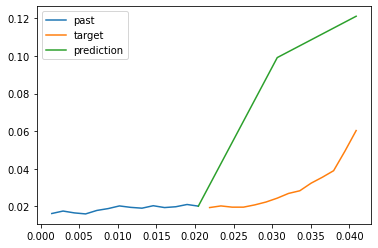

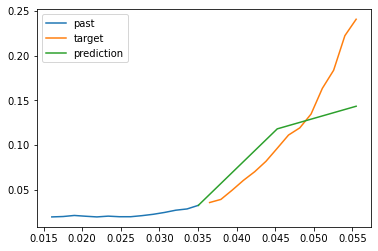

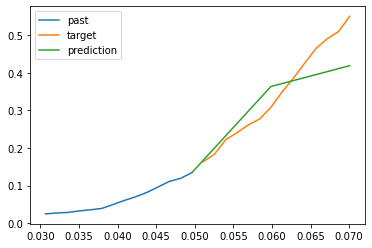

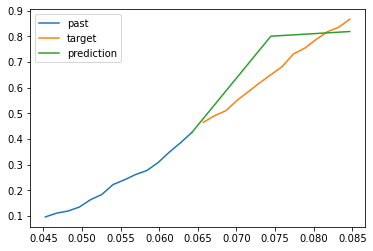

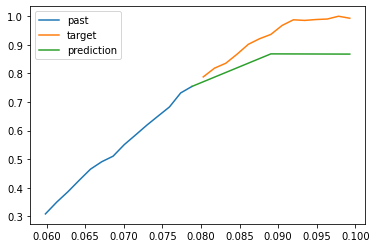

In [435]:
predictions = []
for i in range(1, 50, 10):
    with torch.no_grad():
        pred = model((train_input_days[i:i+1], train_input_ospedalizzati[i:i+1], train_input_perc[i:i+1]))
        predictions.append(pred[0])

for p, i in enumerate(range(1, 50, 10)):
    days = training_set[i, :, 0]
    ospedalizzati = training_set[i, :, 1]
    plt.plot(days[:14], ospedalizzati[:14], label="past")
    plt.plot(days[14:], ospedalizzati[14:], label="target")
    plt.plot([days[13], days[20], days[27]], [ospedalizzati[13], *predictions[p]], label="prediction")
    plt.legend()
    plt.show()

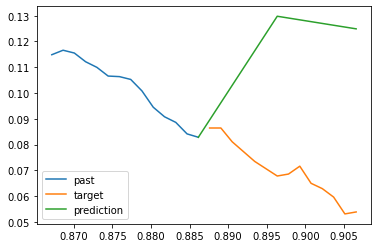

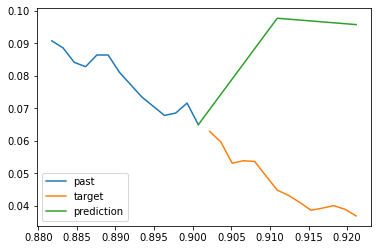

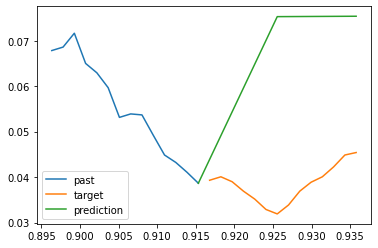

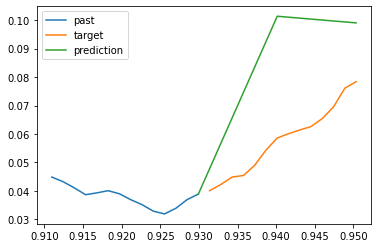

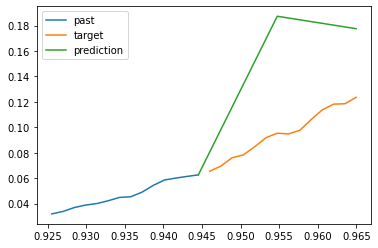

In [436]:
predictions = []
for i in range(1, 50, 10):
    with torch.no_grad():
        pred = model((test_input_days[i:i+1], test_input_ospedalizzati[i:i+1], test_input_perc[i:i+1]))
        predictions.append(pred[0])

for p, i in enumerate(range(1, 50, 10)):
    days = test_set[i, :, 0]
    ospedalizzati = test_set[i, :, 1]
    plt.plot(days[:14], ospedalizzati[:14], label="past")
    plt.plot(days[14:], ospedalizzati[14:], label="target")
    plt.plot([days[13], days[20], days[27]], [ospedalizzati[13], *predictions[p]], label="prediction")
    plt.legend()
    plt.show()